In [1]:
import sys
sys.path.append("..")
from utils import read_patients_metadata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_lesions, apply_cleaner, load_patient_lesions, read_patients_metadata, get_folds_structure
from config import *
import numpy as np
import pandas as pd

Loading configuration...
Configuration loaded successfully!
_____________________________



In [2]:
FOLDS_VERSION = "all"

In [3]:

data = read_patients_metadata(PATCH_SIZE)

In [83]:

def get_dataframe_from_metadata(only_cleaned=True):
    # We process the data
    folds = get_folds_structure(version=FOLDS_VERSION)
    data_list = []
    for i in range(len(folds)):
        pd_data = [("Basel" if db == 0 else "Lausanne", pat, les, "Rim+" if int(les) // 1000 == 1 else "Rim-", 
                    i, int(data[db][int(pat)][les]["volume"]), 
                    data[db][int(pat)][les]["ignore"],
                    np.NaN if len(data[db][int(pat)][les]["reasons_to_ignore"]) == 0 else get_reason(int(min(data[db][int(pat)][les]["reasons_to_ignore"]))),
                    data[db][int(pat)][les]["reasons_to_ignore"],
                    len([1 for les in data[db][int(pat)] if int(les) // 1000 == 1 and not data[db][int(pat)][les]["ignore"]]),
                    len([les for les in data[db][int(pat)] if not data[db][int(pat)][les]["ignore"]]))
                   for (db, pat) in folds[i]
                   for les in data[db][int(pat)]
                   if (not only_cleaned) or (not data[db][int(pat)][les]["ignore"])]
        data_list.append(pd.DataFrame(data = pd_data, columns=["Dataset", "Patient", "Lesion", "Type", "Fold", "Volume", "Ignore", "Main_reason", "Reasons", "NumRims", "TotalLesions"]))
    df = pd.concat(data_list)
    
    df["Group"] = df["NumRims"].apply(lambda n_rims: get_group(n_rims))
    df["Label"] = df["NumRims"].apply(lambda n_rims: get_label(n_rims))
    return df

def get_group(nrims):
    if nrims == 0:
        return "Group 1 (no rims)"
    elif nrims <= 3:
        return "Group 2 (1-3 rims)"
    else:
        return "Group 3 (≥4 rims)"

def get_label(nrims):
    if nrims <= 11:
        return f"{nrims}"
    else:
        return "≥12"

In [84]:
df = get_dataframe_from_metadata()

In [85]:
def show_patient_groups_by_rims(dataset = None):
    plt.figure(0)
    sns.set(style="whitegrid")
    order = tuple([str(i) for i in range(12)] + ["≥12"])
    if dataset is None:
        pats = len(df.groupby("Patient").first().index)
        ax = sns.countplot(data = df.groupby("Patient").first().sort_values("Label"), x="Label", hue="Group", dodge=False, order=order, palette=sns.color_palette("Blues_r", 3), edgecolor="black")
        ax.set_title(f"Patients by number of rim+ lesions")
        ax.set_ylim((0, 60))
    else:
        pats = len(df[df["Dataset"] == dataset].groupby("Patient").first().index)
        ax = sns.countplot(data = df[df["Dataset"] == dataset].groupby("Patient").first().sort_values("Label"), x="Label", hue="Group", dodge=False, order=order, palette=sns.color_palette("Blues_r", 3), edgecolor="black")
        ax.set_title(f"Patients by number of rim+ lesions - {dataset}")
        ax.set_ylim((0, 30))
    
    print(f'#Patients = {pats}')
    ax.set_xlabel('Nº of rim+ lesions')
    ax.set_ylabel('Nº of patients')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    #ax.set_yticks((10, 20, 30, 40))
    plt.savefig(f'./figs/rims_count_{dataset}.pdf', dpi = 400, format='pdf')
    

#Patients = 55


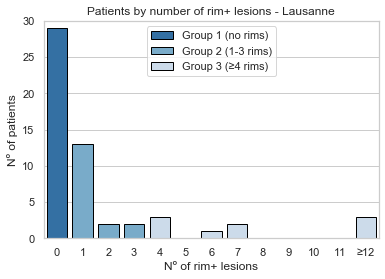

In [86]:
show_patient_groups_by_rims("Lausanne")

#Patients = 69


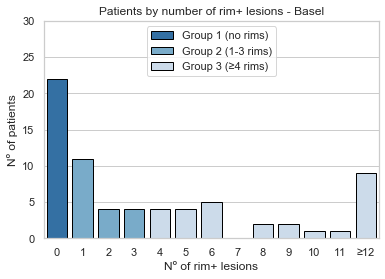

In [87]:

show_patient_groups_by_rims("Basel")

#Patients = 124


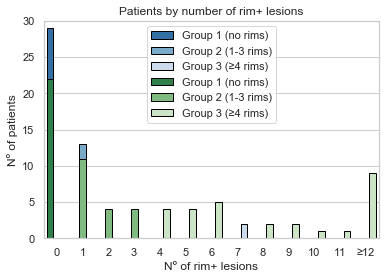

In [91]:
def show_patient_groups_by_rims_v2():
    plt.figure(0)
    sns.set(style="whitegrid")
    order = tuple([str(i) for i in range(12)] + ["≥12"])
    
    pats = len(df.groupby("Patient").first().index)
    df["Group_H"] = df.apply(lambda r: "Basel - " + r["Group"] if r["Dataset"] == "Basel" else "Lausanne - " + r["Group"], axis=1)
    ax = sns.countplot(data = df[df["Dataset"] == "Lausanne"].groupby("Patient").first().sort_values("Label"), x="Label", hue="Group", dodge=True, order=order, palette=sns.color_palette("Blues_r", 3), edgecolor="black")
    ax = sns.countplot(data = df[df["Dataset"] == "Basel"].groupby("Patient").first().sort_values("Label"), x="Label", hue="Group", dodge=True, order=order, palette=sns.color_palette("Greens_r", 3), edgecolor="black")
    
    ax.set_title(f"Patients by number of rim+ lesions")
    ax.set_ylim((0, 30))
    
    print(f'#Patients = {pats}')
    ax.set_xlabel('Nº of rim+ lesions')
    ax.set_ylabel('Nº of patients')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    #ax.set_yticks((10, 20, 30, 40))
    plt.savefig(f'./figs/rims_count_v2.pdf', dpi = 400, format='pdf')
    
show_patient_groups_by_rims_v2()

#Patients = 55


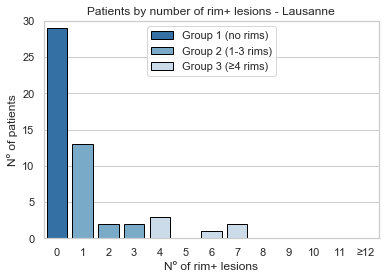

In [24]:

show_patient_groups_by_rims("Lausanne")

Text(0.5, 1.0, 'Histogram of patients by number of lesions')

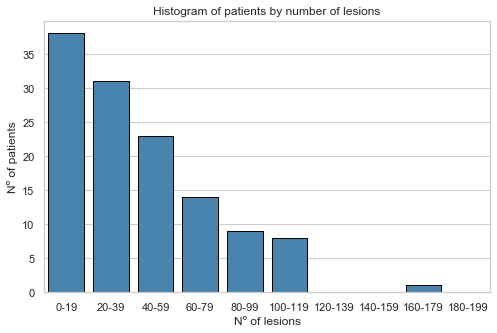

In [92]:

import pandas as pd

len_group = 20
df["Label_Total"] = df["TotalLesions"].apply(lambda n_lesions: f"{len_group * (n_lesions // len_group)}-{len_group + (len_group * (n_lesions // len_group)) - 1}")
order = [f"{len_group * (n_lesions // len_group)}-{len_group + (len_group * (n_lesions // len_group)) - 1}" for n_lesions in range(0, 200, len_group)]

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
ax = sns.countplot(data = df.groupby("Patient").first(), x="Label_Total", order=order, dodge=False, palette=sns.color_palette("Blues_d", 1), edgecolor="black")
ax.set_xlabel('Nº of lesions')
ax.set_ylabel('Nº of patients')
ax.set_title("Histogram of patients by number of lesions")
#plt.savefig(f'../figs/total_lesions_count.pdf', dpi = 400, format='pdf')

array([[1.        , 0.40915941],
       [0.40915941, 1.        ]])

<Figure size 432x273.6 with 0 Axes>

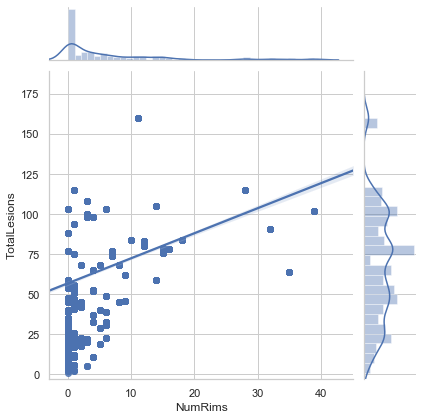

In [94]:

plt.figure(figsize=(6, 3.8))
plot = sns.jointplot(x = "NumRims", y = "TotalLesions", data=df, kind='reg')
ax = plot.ax_marg_x
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles, labels=labels)
#ax.set_yticks((10, 20, 30, 40))
#ax.set_ylim((0, 45))
#ax.set_title("Histogram of patients by number of rim+ lesions")
plot.ax_marg_x.set_xlim(-3,)
plot.ax_marg_y.set_ylim(-3,)
plt.savefig(f'../figs/joinplot_rim.pdf', dpi = 400, format='pdf')

np.corrcoef(df["NumRims"], y=df["TotalLesions"])